In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
nycgreentaxi=pd.read_parquet("/content/drive/MyDrive/green_tripdata_2024-07.parquet")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
nycgreentaxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51837 entries, 0 to 51836
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               51837 non-null  int32         
 1   lpep_pickup_datetime   51837 non-null  datetime64[us]
 2   lpep_dropoff_datetime  51837 non-null  datetime64[us]
 3   store_and_fwd_flag     50228 non-null  object        
 4   RatecodeID             50228 non-null  float64       
 5   PULocationID           51837 non-null  int32         
 6   DOLocationID           51837 non-null  int32         
 7   passenger_count        50228 non-null  float64       
 8   trip_distance          51837 non-null  float64       
 9   fare_amount            51837 non-null  float64       
 10  extra                  51837 non-null  float64       
 11  mta_tax                51837 non-null  float64       
 12  tip_amount             51837 non-null  float64       
 13  t

In [14]:
nycgreentaxi = nycgreentaxi.drop(["ehail_fee", "fare_amount"], axis=1, errors='ignore')

In [16]:
nycgreentaxi["trip_duration"] = nycgreentaxi.lpep_dropoff_datetime - nycgreentaxi.lpep_pickup_datetime
nycgreentaxi["trip_duration"] = nycgreentaxi["trip_duration"].dt.total_seconds() / 60  # convert to minutes

In [18]:
nycgreentaxi["weekday"] = nycgreentaxi["lpep_dropoff_datetime"].dt.day_name()
nycgreentaxi["hour"] = nycgreentaxi["lpep_dropoff_datetime"].dt.hour

In [20]:
# Missing value imputation
num_cols = ['trip_distance', 'extra', 'mta_tax', 'tip_amount',
            'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
            'trip_duration', 'passenger_count', 'RatecodeID', 'payment_type', 'trip_type']
for col in num_cols:
    if col in nycgreentaxi.columns:
        nycgreentaxi[col] = nycgreentaxi[col].fillna(nycgreentaxi[col].median())

In [22]:
cat_cols = ['store_and_fwd_flag', 'weekday', 'hour']
for col in cat_cols:
    if col in nycgreentaxi.columns:
        nycgreentaxi[col] = nycgreentaxi[col].fillna(nycgreentaxi[col].mode()[0])

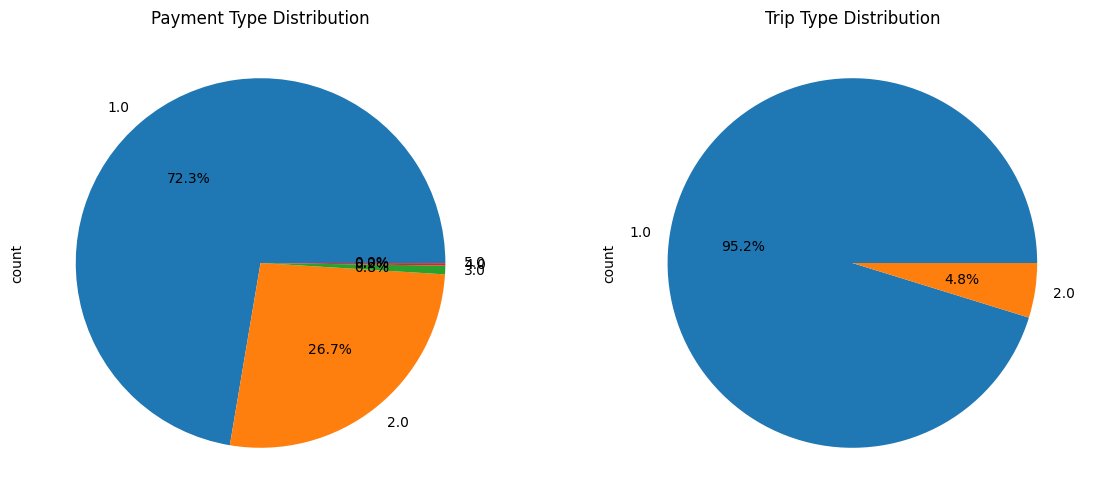

In [24]:
# Pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
nycgreentaxi['payment_type'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0])
axes[0].set_title('Payment Type Distribution')
nycgreentaxi['trip_type'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1])
axes[1].set_title('Trip Type Distribution')
plt.show()

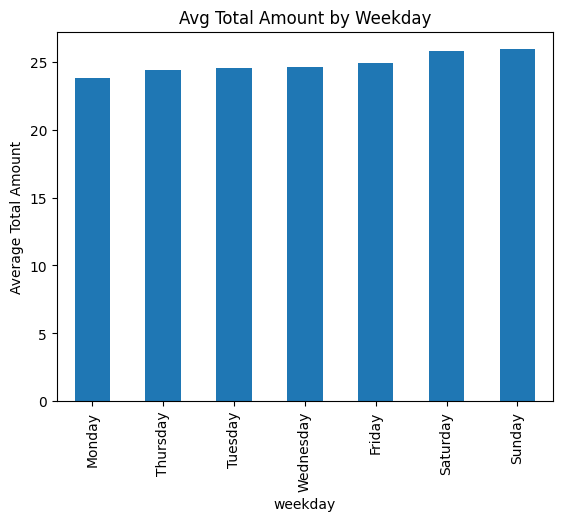

In [26]:
# Bar plots
nycgreentaxi.groupby('weekday')['total_amount'].mean().sort_values().plot(kind='bar', title='Avg Total Amount by Weekday')
plt.ylabel('Average Total Amount')
plt.show()

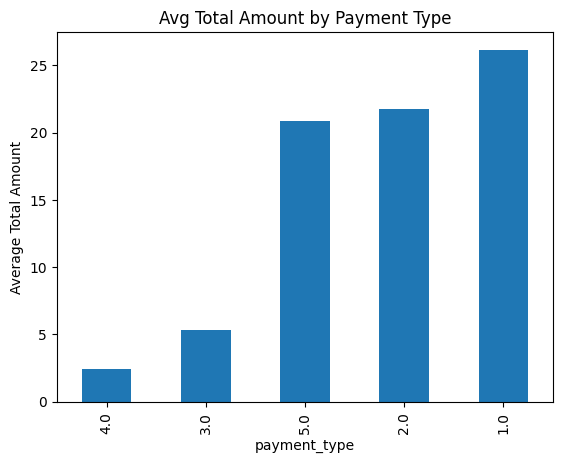

In [28]:
nycgreentaxi.groupby('payment_type')['total_amount'].mean().sort_values().plot(kind='bar', title='Avg Total Amount by Payment Type')
plt.ylabel('Average Total Amount')
plt.show()

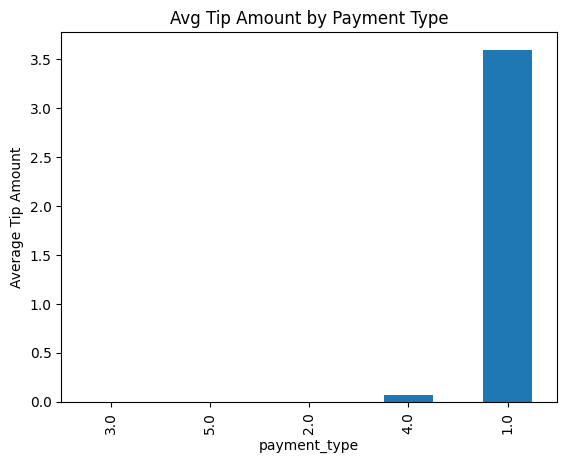

In [32]:
nycgreentaxi.groupby('payment_type')['tip_amount'].mean().sort_values().plot(kind='bar', title='Avg Tip Amount by Payment Type')
plt.ylabel('Average Tip Amount')
plt.show()

In [34]:
# ANOVA tests
trip_type_groups = [nycgreentaxi[nycgreentaxi['trip_type'] == i]['total_amount'] for i in nycgreentaxi['trip_type'].unique()]
f_val, p_val = stats.f_oneway(*trip_type_groups)
print(f"ANOVA test for trip_type: F = {f_val}, p = {p_val}")

ANOVA test for trip_type: F = 3200.048812406439, p = 0.0


In [36]:
weekday_groups = [nycgreentaxi[nycgreentaxi['weekday'] == day]['total_amount'] for day in nycgreentaxi['weekday'].unique()]
f_val, p_val = stats.f_oneway(*weekday_groups)
print(f"ANOVA test for weekday: F = {f_val}, p = {p_val}")

ANOVA test for weekday: F = 8.624356732458981, p = 2.1206136640718346e-09


In [38]:
# Chi-square test
contingency_table = pd.crosstab(nycgreentaxi['trip_type'], nycgreentaxi['payment_type'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square test: Chi2 = {chi2}, p = {p}")

Chi-square test: Chi2 = 153.51598464745092, p = 3.5906455059949627e-32


In [40]:
# Correlation heatmap
num_vars = ['trip_distance', 'extra', 'mta_tax', 'tip_amount',
            'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
            'trip_duration', 'passenger_count', 'total_amount']
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

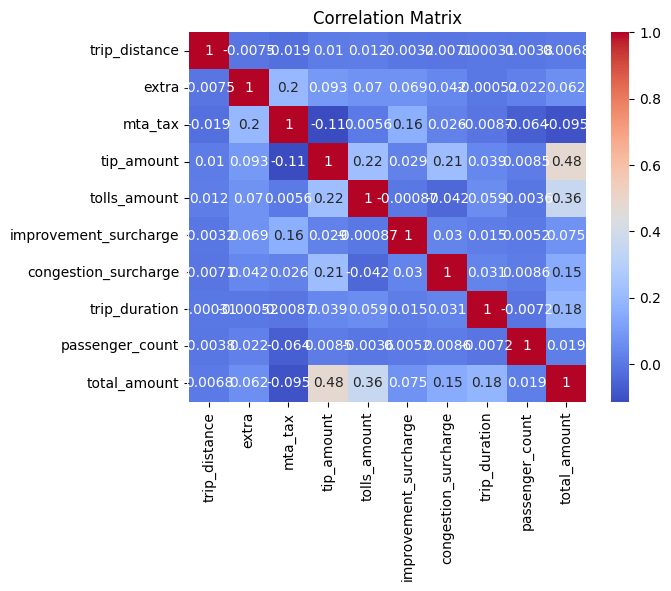

In [42]:
sns.heatmap(nycgreentaxi[num_vars].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [44]:
# Encode categorical variables
obj_vars = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type', 'weekday']
nyc_encoded = pd.get_dummies(nycgreentaxi, columns=obj_vars, drop_first=True)

Text(0.5, 1.0, 'Histogram of Total Amount')

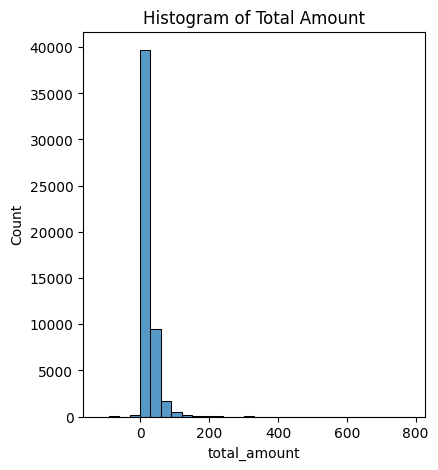

In [46]:
# Total amount analysis
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(nycgreentaxi['total_amount'], kde=False, bins=30)
plt.title('Histogram of Total Amount')

Text(0.5, 1.0, 'Boxplot of Total Amount')

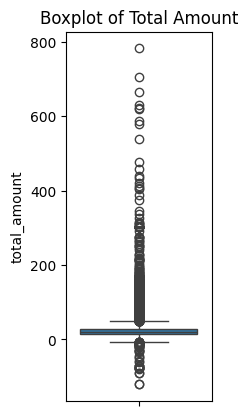

In [48]:
plt.subplot(1, 3, 2)
sns.boxplot(y=nycgreentaxi['total_amount'])
plt.title('Boxplot of Total Amount')

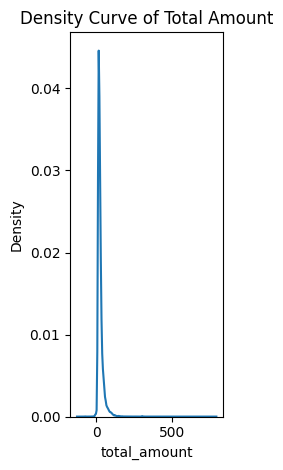

In [50]:
plt.subplot(1, 3, 3)
sns.kdeplot(nycgreentaxi['total_amount'])
plt.title('Density Curve of Total Amount')
plt.tight_layout()
plt.show()

In [52]:
# Regression models
X = nyc_encoded.drop(['total_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'VendorID'], axis=1, errors='ignore')
y = nyc_encoded['total_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("\nLinear Regression:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")


Linear Regression:
RMSE: 16.850830026191574
R2 Score: 0.3939065198983007


In [56]:
# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("\nDecision Tree:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")


Decision Tree:
RMSE: 15.71558526912314
R2 Score: 0.47282095973607907


In [59]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("\nRandom Forest:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")


Random Forest:
RMSE: 10.563568099904522
R2 Score: 0.7618128712284366


In [60]:
# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print("\nGradient Boosting:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")


Gradient Boosting:
RMSE: 10.279606093182034
R2 Score: 0.774446296364054
